In [ ]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, roc_curve, mean_absolute_percentage_error)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression, RFE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузка данных
# Классификация
df_cancer = pd.read_csv('/content/breast-cancer.csv.xls')
# Регрессия
df_cars = pd.read_csv('/content/CAR DETAILS FROM CAR DEKHO.csv.xls')

# Создание бейзлайна и оценка качества

In [ ]:
# Подготовка данных для классификации
df_cancer_clean = df_cancer.drop('id', axis=1)
le = LabelEncoder()
df_cancer_clean['diagnosis'] = le.fit_transform(df_cancer_clean['diagnosis'])  # 1 - Malignant, 0 - Benign

# Разделим на признаки и таргет
X_clf = df_cancer_clean.drop('diagnosis', axis=1)
y_clf = df_cancer_clean['diagnosis']

# Разделение на train/test
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

In [ ]:
# Подготовка данных для регрессии
df_cars_clean = df_cars.copy()

# Кодируем категориальные признаки
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner']
for col in cat_cols:
    le_temp = LabelEncoder()
    df_cars_clean[col] = le_temp.fit_transform(df_cars_clean[col])

# Также преобразуем 'name' в категориальный код
df_cars_clean['name'] = LabelEncoder().fit_transform(df_cars_clean['name'])

X_reg = df_cars_clean.drop('selling_price', axis=1)
y_reg = df_cars_clean['selling_price']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [ ]:
# Создаем и обучаем базовые модели случайного леса
# Классификация
rf_clf_baseline = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf_baseline.fit(X_train_clf, y_train_clf)

# Регрессия
rf_reg_baseline = RandomForestRegressor(random_state=42, n_estimators=100)
rf_reg_baseline.fit(X_train_reg, y_train_reg)

RandomForestRegressor(random_state=42)

Оценим качество моделей бейзлайна

In [ ]:
# Прогноз для классификации
y_pred_clf_baseline = rf_clf_baseline.predict(X_test_clf)
y_pred_proba_baseline = rf_clf_baseline.predict_proba(X_test_clf)[:, 1]

# Оценка качества классификации
print("=== КЛАССИФИКАЦИЯ (Базовый случайный лес) ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf_baseline):.4f}")
print(f"Precision (M): {precision_score(y_test_clf, y_pred_clf_baseline):.4f}")
print(f"Recall (M): {recall_score(y_test_clf, y_pred_clf_baseline):.4f}")
print(f"F1-score (M): {f1_score(y_test_clf, y_pred_clf_baseline):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_baseline):.4f}")

print("\n" + classification_report(y_test_clf, y_pred_clf_baseline, target_names=['Benign', 'Malignant']))

=== КЛАССИФИКАЦИЯ (Базовый случайный лес) ===
Accuracy: 0.9737
Precision (M): 1.0000
Recall (M): 0.9286
F1-score (M): 0.9630
ROC-AUC: 0.9929

              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        72
   Malignant       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



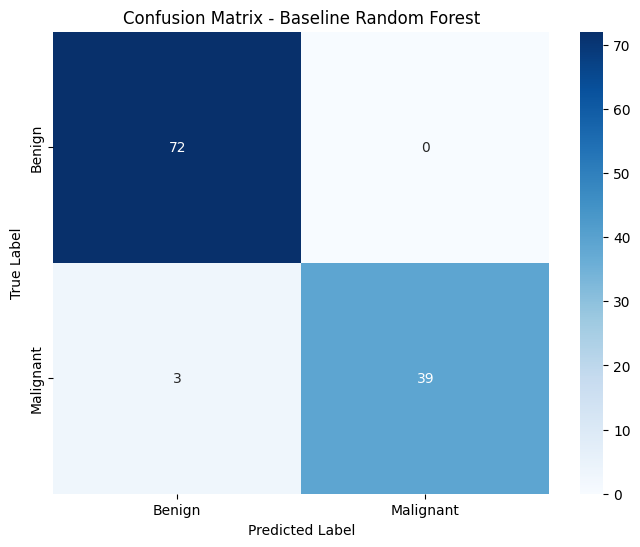

In [ ]:
# Матрица ошибок
cm = confusion_matrix(y_test_clf, y_pred_clf_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Baseline Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

=== РЕГРЕССИЯ (Базовый случайный лес) ===
MAE: 107868.69
MSE: 92712993494.66
RMSE: 304488.08
R²: 0.6962
MAPE: 0.2624


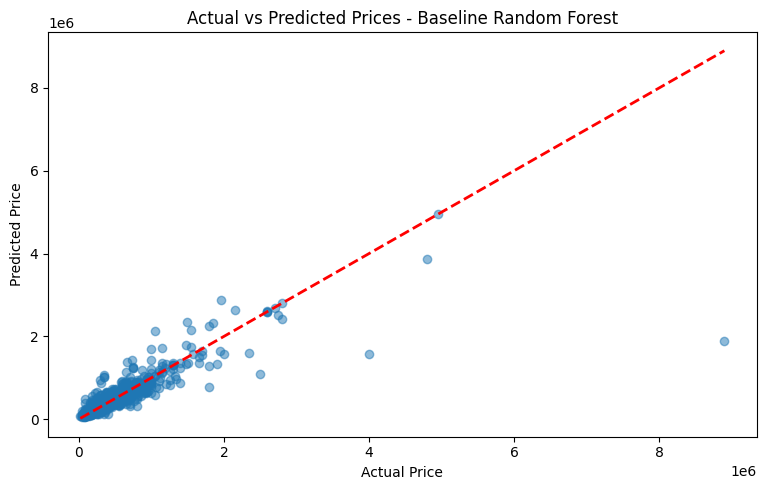

In [ ]:
# Оценка качества регрессии
y_pred_reg_baseline = rf_reg_baseline.predict(X_test_reg)

print("=== РЕГРЕССИЯ (Базовый случайный лес) ===")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_reg_baseline):.2f}")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_reg_baseline):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_baseline)):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_reg_baseline):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test_reg, y_pred_reg_baseline):.4f}")

# Визуализация предсказаний
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_reg, y_pred_reg_baseline, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices - Baseline Random Forest')

plt.tight_layout()
plt.show()

# Гипотезы для улучшения моделей случайного леса:

1. Для классификации (рак груди):
   - Масштабирование признаков может улучшить производительность
   - Подбор гиперпараметров (n_estimators, max_depth, min_samples_split)
   - Использование PCA для уменьшения размерности
   - Балансировка классов (хотя у нас и так сбалансированные данные)
   - Использование кросс-валидации для более надежной оценки

2. Для регрессии (автомобили):
   - Создание новых признаков (возраст автомобиля, логарифм цены)
   - Обработка выбросов в целевой переменной
   - Масштабирование признаков
   - Подбор гиперпараметров
   - Использование One-Hot Encoding вместо Label Encoding
   - Логарифмическое преобразование целевой переменной

# Улучшение бейзлайна

Проверка гипотез для классификации

In [ ]:
# 1. Масштабирование признаков
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

rf_clf_scaled = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf_scaled.fit(X_train_clf_scaled, y_train_clf)
y_pred_clf_scaled = rf_clf_scaled.predict(X_test_clf_scaled)

print("=== КЛАССИФИКАЦИЯ с масштабированием признаков ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf_scaled):.4f}")
print(f"F1-score: {f1_score(y_test_clf, y_pred_clf_scaled):.4f}")

=== КЛАССИФИКАЦИЯ с масштабированием признаков ===
Accuracy: 0.9737
F1-score: 0.9630


In [ ]:
# 2. Подбор гиперпараметров с кросс-валидацией
param_grid_clf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_clf_cv = RandomForestClassifier(random_state=42)
grid_search_clf = RandomizedSearchCV(
    rf_clf_cv, param_grid_clf, n_iter=20, cv=5,
    scoring='roc_auc', n_jobs=-1, random_state=42
)
grid_search_clf.fit(X_train_clf, y_train_clf)

print("=== КЛАССИФИКАЦИЯ с подбором гиперпараметров ===")
print(f"Лучшие параметры: {grid_search_clf.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search_clf.best_score_:.4f}")

=== КЛАССИФИКАЦИЯ с подбором гиперпараметров ===
Лучшие параметры: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Лучший ROC-AUC на кросс-валидации: 0.9916


In [ ]:
# 3. Воспользуемся методом главных компонент
pca_clf = PCA(n_components=0.95)
X_train_pca = pca_clf.fit_transform(X_train_clf_scaled)
X_test_pca = pca_clf.transform(X_test_clf_scaled)

rf_clf_pca = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf_pca.fit(X_train_pca, y_train_clf)
y_pred_clf_pca = rf_clf_pca.predict(X_test_pca)

print("=== КЛАССИФИКАЦИЯ с PCA (95% дисперсии) ===")
print(f"Исходная размерность: {X_train_clf.shape[1]}")
print(f"Размерность после PCA: {X_train_pca.shape[1]}")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf_pca):.4f}")

=== КЛАССИФИКАЦИЯ с PCA (95% дисперсии) ===
Исходная размерность: 30
Размерность после PCA: 10
Accuracy: 0.9386


Проверка гипотез для регрессии

In [ ]:
# 1. Логарифмическое преобразование целевой переменной
y_train_reg_log = np.log1p(y_train_reg)
y_test_reg_log = np.log1p(y_test_reg)

rf_reg_log = RandomForestRegressor(random_state=42, n_estimators=100)
rf_reg_log.fit(X_train_reg, y_train_reg_log)
y_pred_reg_log = rf_reg_log.predict(X_test_reg)
y_pred_reg_log_exp = np.expm1(y_pred_reg_log)

print("=== РЕГРЕССИЯ с логарифмированием целевой переменной ===")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_reg_log_exp):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_log_exp)):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_reg_log_exp):.4f}")

=== РЕГРЕССИЯ с логарифмированием целевой переменной ===
MAE: 104437.43
RMSE: 306786.29
R²: 0.6916


In [ ]:
# 2. Создание новых признаков
df_cars_enhanced = df_cars.copy()

# Создаем дополнительные признаки
df_cars_enhanced['car_age'] = 2023 - df_cars_enhanced['year']
df_cars_enhanced['km_per_year'] = df_cars_enhanced['km_driven'] / (df_cars_enhanced['car_age'] + 1)
df_cars_enhanced['price_per_km'] = df_cars_enhanced['selling_price'] / (df_cars_enhanced['km_driven'] + 1)

# One-Hot Encoding вместо Label Encoding
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner']
df_cars_encoded = pd.get_dummies(df_cars_enhanced, columns=cat_cols, drop_first=True)

# Преобразуем 'name' с помощью частотного кодирования
name_freq = df_cars_encoded['name'].value_counts() / len(df_cars_encoded)
df_cars_encoded['name_freq'] = df_cars_encoded['name'].map(name_freq)
df_cars_encoded = df_cars_encoded.drop('name', axis=1)

X_reg_enhanced = df_cars_encoded.drop('selling_price', axis=1)
y_reg_enhanced = df_cars_encoded['selling_price']

X_train_reg_enh, X_test_reg_enh, y_train_reg_enh, y_test_reg_enh = train_test_split(
    X_reg_enhanced, y_reg_enhanced, test_size=0.2, random_state=42
)

rf_reg_enhanced = RandomForestRegressor(random_state=42, n_estimators=100)
rf_reg_enhanced.fit(X_train_reg_enh, y_train_reg_enh)
y_pred_reg_enhanced = rf_reg_enhanced.predict(X_test_reg_enh)

print("=== РЕГРЕССИЯ с новыми признаками и One-Hot Encoding ===")
print(f"Количество признаков: {X_reg_enhanced.shape[1]}")
print(f"MAE: {mean_absolute_error(y_test_reg_enh, y_pred_reg_enhanced):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg_enh, y_pred_reg_enhanced)):.2f}")
print(f"R²: {r2_score(y_test_reg_enh, y_pred_reg_enhanced):.4f}")

=== РЕГРЕССИЯ с новыми признаками и One-Hot Encoding ===
Количество признаков: 17
MAE: 34269.51
RMSE: 192665.37
R²: 0.8784


In [ ]:
# 3. Подбор гиперпараметров для регрессии
param_grid_reg = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf_reg_cv = RandomForestRegressor(random_state=42)
grid_search_reg = RandomizedSearchCV(
    rf_reg_cv, param_grid_reg, n_iter=15, cv=5,
    scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
grid_search_reg.fit(X_train_reg, y_train_reg)

print("\n=== РЕГРЕССИЯ с подбором гиперпараметров ===")
print(f"Лучшие параметры: {grid_search_reg.best_params_}")
print(f"Лучший MSE на кросс-валидации: {-grid_search_reg.best_score_:.2f}")


=== РЕГРЕССИЯ с подбором гиперпараметров ===
Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Лучший MSE на кросс-валидации: 74993101472.41


Создание улучшенного пайплайна на основе проверенных гипотез

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor

In [ ]:
# Улучшенный пайплайн для классификации
def create_enhanced_clf_pipeline():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', RandomForestClassifier(
            random_state=42,
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt'
        ))
    ])
    return pipeline

# Улучшенный пайплайн для регрессии
def create_enhanced_reg_pipeline():
    # Функция для создания новых признаков
    def create_new_features(X):
        X = X.copy()
        if 'year' in X.columns:
            X['car_age'] = 2023 - X['year']
        if 'km_driven' in X.columns and 'car_age' in X.columns:
            X['km_per_year'] = X['km_driven'] / (X['car_age'] + 1)
        return X

    # Основной пайплайн
    pipeline = Pipeline([
        ('feature_creator', FunctionTransformer(create_new_features)),
        ('regressor', RandomForestRegressor(
            random_state=42,
            n_estimators=300,
            max_depth=30,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt'
        ))
    ])

    # Преобразование целевой переменной
    enhanced_model = TransformedTargetRegressor(
        regressor=pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )

    return enhanced_model

In [ ]:
# Обучение улучшенной модели для классификации
enhanced_clf_pipeline = create_enhanced_clf_pipeline()
enhanced_clf_pipeline.fit(X_train_clf, y_train_clf)
y_pred_clf_enhanced = enhanced_clf_pipeline.predict(X_test_clf)
y_pred_proba_enhanced = enhanced_clf_pipeline.predict_proba(X_test_clf)[:, 1]

# Обучение улучшенной модели для регрессии
enhanced_reg_pipeline = create_enhanced_reg_pipeline()
enhanced_reg_pipeline.fit(X_train_reg, y_train_reg)
y_pred_reg_enhanced = enhanced_reg_pipeline.predict(X_test_reg)

=== КЛАССИФИКАЦИЯ (Улучшенный случайный лес) ===
Accuracy: 0.9474
Precision (M): 0.9500
Recall (M): 0.9048
F1-score (M): 0.9268
ROC-AUC: 0.9917

              precision    recall  f1-score   support

      Benign       0.95      0.97      0.96        72
   Malignant       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



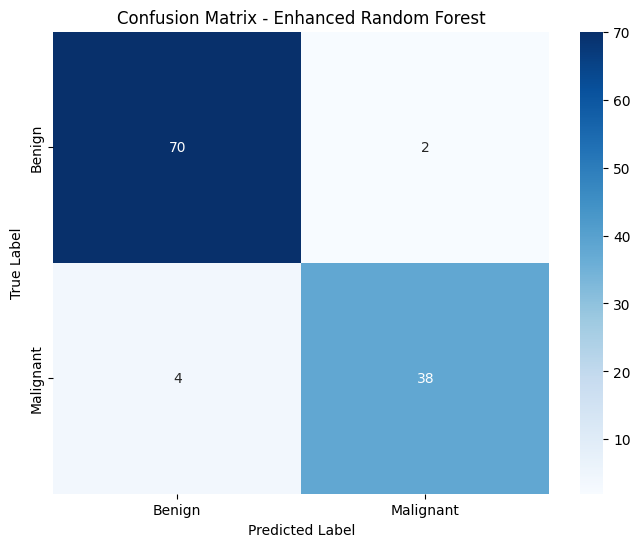

In [ ]:
# Оценка улучшенной модели классификации
print("=== КЛАССИФИКАЦИЯ (Улучшенный случайный лес) ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf_enhanced):.4f}")
print(f"Precision (M): {precision_score(y_test_clf, y_pred_clf_enhanced):.4f}")
print(f"Recall (M): {recall_score(y_test_clf, y_pred_clf_enhanced):.4f}")
print(f"F1-score (M): {f1_score(y_test_clf, y_pred_clf_enhanced):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_enhanced):.4f}")

print("\n" + classification_report(y_test_clf, y_pred_clf_enhanced, target_names=['Benign', 'Malignant']))

# Матрица ошибок для улучшенной модели
cm_enhanced = confusion_matrix(y_test_clf, y_pred_clf_enhanced)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_enhanced, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Enhanced Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

=== РЕГРЕССИЯ (Улучшенный случайный лес) ===
MAE: 131615.62
MSE: 117800117923.00
RMSE: 343220.22
R²: 0.6140
MAPE: 0.2834


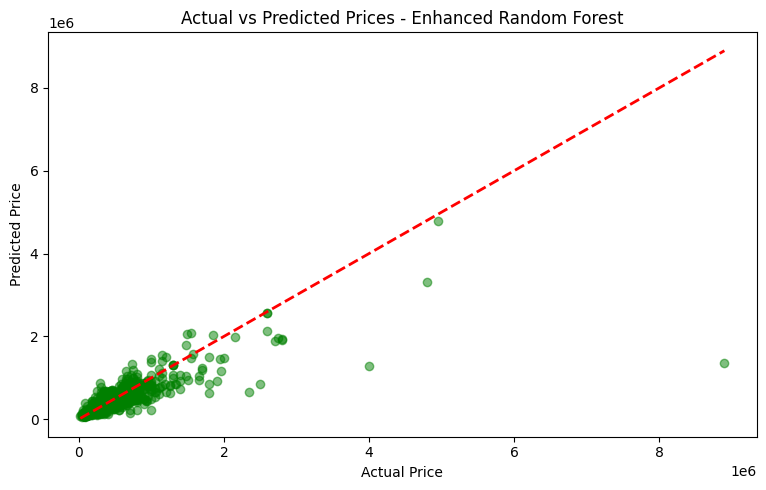

In [ ]:
# Оценка улучшенной модели регрессии
print("=== РЕГРЕССИЯ (Улучшенный случайный лес) ===")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_reg_enhanced):.2f}")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_reg_enhanced):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_enhanced)):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_reg_enhanced):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test_reg, y_pred_reg_enhanced):.4f}")

# Визуализация предсказаний улучшенной модели
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_reg, y_pred_reg_enhanced, alpha=0.5, color='green')
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices - Enhanced Random Forest')

plt.tight_layout()
plt.show()

# Имплементация алгоритма машинного обучения

In [ ]:
# Имплементация простого случайного леса для классификации
class SimpleRandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_features = X.shape[1]

        for i in range(self.n_estimators):
            # Бутстрэп выборка
            X_sample, y_sample = self._bootstrap_sample(X.values, y.values)

            # Случайный выбор признаков
            n_features_sample = int(np.sqrt(n_features))
            feature_indices = np.random.choice(n_features, n_features_sample, replace=False)
            self.feature_indices.append(feature_indices)

            # Обучение дерева
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                random_state=self.random_state + i if self.random_state else None
            )
            tree.fit(X_sample[:, feature_indices], y_sample)
            self.trees.append(tree)

    def predict_proba(self, X):
        probas = []
        for tree, feature_indices in zip(self.trees, self.feature_indices):
            proba = tree.predict_proba(X.values[:, feature_indices])
            probas.append(proba)

        # Усреднение предсказаний
        avg_proba = np.mean(probas, axis=0)
        return avg_proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [ ]:
# Имплементация простого случайного леса для регрессии
class SimpleRandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_features = X.shape[1]

        for i in range(self.n_estimators):
            # Бутстрэп выборка
            X_sample, y_sample = self._bootstrap_sample(X.values, y.values)

            # Случайный выбор признаков
            n_features_sample = int(np.sqrt(n_features))
            feature_indices = np.random.choice(n_features, n_features_sample, replace=False)
            self.feature_indices.append(feature_indices)

            # Обучение дерева
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state + i if self.random_state else None
            )
            tree.fit(X_sample[:, feature_indices], y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = []
        for tree, feature_indices in zip(self.trees, self.feature_indices):
            pred = tree.predict(X.values[:, feature_indices])
            predictions.append(pred)

        # Усреднение предсказаний
        avg_pred = np.mean(predictions, axis=0)
        return avg_pred

In [ ]:
# Обучение имплементированной модели для классификации
simple_rf_clf = SimpleRandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
simple_rf_clf.fit(X_train_clf, y_train_clf)
y_pred_simple_clf = simple_rf_clf.predict(X_test_clf)
y_pred_proba_simple_clf = simple_rf_clf.predict_proba(X_test_clf)

# Обучение имплементированной модели для регрессии
simple_rf_reg = SimpleRandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
simple_rf_reg.fit(X_train_reg, y_train_reg)
y_pred_simple_reg = simple_rf_reg.predict(X_test_reg)

In [ ]:
# Оценка имплементированной модели классификации
print("=== КЛАССИФИКАЦИЯ (Имплементированный случайный лес) ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_simple_clf):.4f}")
print(f"Precision (M): {precision_score(y_test_clf, y_pred_simple_clf):.4f}")
print(f"Recall (M): {recall_score(y_test_clf, y_pred_simple_clf):.4f}")
print(f"F1-score (M): {f1_score(y_test_clf, y_pred_simple_clf):.4f}")

if hasattr(y_pred_proba_simple_clf, 'shape') and y_pred_proba_simple_clf.shape[1] > 1:
    print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_simple_clf[:, 1]):.4f}")
else:
    print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_simple_clf):.4f}")

print("\n" + classification_report(y_test_clf, y_pred_simple_clf, target_names=['Benign', 'Malignant']))

=== КЛАССИФИКАЦИЯ (Имплементированный случайный лес) ===
Accuracy: 0.9649
Precision (M): 1.0000
Recall (M): 0.9048
F1-score (M): 0.9500
ROC-AUC: 0.9977

              precision    recall  f1-score   support

      Benign       0.95      1.00      0.97        72
   Malignant       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
# Оценка имплементированной модели регрессии
print("=== РЕГРЕССИЯ (Имплементированный случайный лес) ===")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_simple_reg):.2f}")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_simple_reg):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_simple_reg)):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_simple_reg):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test_reg, y_pred_simple_reg):.4f}")

=== РЕГРЕССИЯ (Имплементированный случайный лес) ===
MAE: 180219.19
MSE: 146894032482.35
RMSE: 383267.57
R²: 0.5186
MAPE: 0.6393


Итак, рещультаты получились сопоставимы с бейзлайном библиотечной модели, что довольно неплохо! Классификация дает хорошие результаты, а регрессия требует улучшений.

# Улучшим наши модели

In [ ]:
class SimpleRandomForestClassifierV2:
    def __init__(self, n_estimators=100, max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []
        if random_state is not None:
            np.random.seed(random_state)

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        # Гарантируем, что X и y - numpy массивы
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            y = np.array(y)

        n_samples, n_features = X.shape

        for i in range(self.n_estimators):
            # Бутстрэп выборка
            X_sample, y_sample = self._bootstrap_sample(X, y)

            # Случайный выбор признаков
            n_features_sample = int(np.sqrt(n_features))
            feature_indices = np.random.choice(n_features, n_features_sample, replace=False)
            self.feature_indices.append(feature_indices)

            # Обучение дерева
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                random_state=self.random_state + i if self.random_state else None
            )
            tree.fit(X_sample[:, feature_indices], y_sample)
            self.trees.append(tree)

    def predict_proba(self, X):
        # Гарантируем, что X - numpy массив
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        probas = []
        for tree, feature_indices in zip(self.trees, self.feature_indices):
            proba = tree.predict_proba(X[:, feature_indices])
            probas.append(proba)

        # Усреднение предсказаний
        avg_proba = np.mean(probas, axis=0)
        return avg_proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

# Улучшенная классификация

In [ ]:
class EnhancedRandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, random_state=None,
                 use_scaling=True, use_pca=False, pca_variance=0.95):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.use_scaling = use_scaling
        self.use_pca = use_pca
        self.pca_variance = pca_variance
        self.scaler = StandardScaler() if use_scaling else None
        self.pca = PCA(n_components=pca_variance) if use_pca else None
        self.rf = SimpleRandomForestClassifierV2(n_estimators, max_depth, random_state)

    def fit(self, X, y):
        # Сохраняем копию данных
        X_original = X.copy()

        # Преобразуем в numpy если нужно
        if isinstance(X_original, pd.DataFrame):
            X_original = X_original.values
        if isinstance(y, pd.Series):
            y = y.values

        # Масштабирование
        if self.use_scaling:
            X_original = self.scaler.fit_transform(X_original)

        # PCA
        if self.use_pca:
            X_original = self.pca.fit_transform(X_original)

        # Обучаем случайный лес
        self.rf.fit(X_original, y)

    def predict_proba(self, X):
        X_original = X.copy()

        # Преобразуем в numpy если нужно
        if isinstance(X_original, pd.DataFrame):
            X_original = X_original.values

        # Масштабирование
        if self.use_scaling:
            X_original = self.scaler.transform(X_original)

        # PCA
        if self.use_pca:
            X_original = self.pca.transform(X_original)

        return self.rf.predict_proba(X_original)

    def predict(self, X):
        X_original = X.copy()

        # Преобразуем в numpy если нужно
        if isinstance(X_original, pd.DataFrame):
            X_original = X_original.values

        # Масштабирование
        if self.use_scaling:
            X_original = self.scaler.transform(X_original)

        # PCA
        if self.use_pca:
            X_original = self.pca.transform(X_original)

        return self.rf.predict(X_original)

# Улучшенная регрессия

In [ ]:
class EnhancedSimpleRandomForestRegressor(SimpleRandomForestRegressor):
    def __init__(self, n_estimators=100, max_depth=None, random_state=None,
                 use_log_transform=True, create_new_features=True):
        super().__init__(n_estimators, max_depth, random_state)
        self.use_log_transform = use_log_transform
        self.create_new_features = create_new_features

    def _create_new_features(self, X):
        X = X.copy()
        if isinstance(X, pd.DataFrame):
            if 'year' in X.columns:
                X['car_age'] = 2023 - X['year']
            if 'km_driven' in X.columns and 'car_age' in X.columns:
                X['km_per_year'] = X['km_driven'] / (X['car_age'] + 1)
        return X

    def fit(self, X, y):
        X = X.copy()
        y = y.copy()

        # Создание новых признаков
        if self.create_new_features:
            X = self._create_new_features(X)

        # Логарифмирование целевой переменной
        if self.use_log_transform:
            y = np.log1p(y)

        super().fit(pd.DataFrame(X), y)
        self._y_is_logged = self.use_log_transform

    def predict(self, X):
        X = X.copy()

        # Создание новых признаков
        if self.create_new_features:
            X = self._create_new_features(X)

        pred = super().predict(pd.DataFrame(X))

        # Обратное преобразование если использовали логарифмирование
        if hasattr(self, '_y_is_logged') and self._y_is_logged:
            pred = np.expm1(pred)

        return pred

In [ ]:
# Обучение исправленной модели
enhanced_rf_clf = EnhancedRandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    use_scaling=True,
    use_pca=True,
    pca_variance=0.95
)
enhanced_rf_clf.fit(X_train_clf, y_train_clf)

# Предсказания
y_pred_enhanced_clf = enhanced_rf_clf.predict(X_test_clf)
y_pred_proba_enhanced_clf = enhanced_rf_clf.predict_proba(X_test_clf)

In [ ]:
# Обучение улучшенной имплементированной модели для регрессии
enhanced_simple_rf_reg = EnhancedSimpleRandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    use_log_transform=True,
    create_new_features=True
)
enhanced_simple_rf_reg.fit(X_train_reg, y_train_reg)
y_pred_enhanced_simple_reg = enhanced_simple_rf_reg.predict(X_test_reg)

In [ ]:
# Оценка улучшенной имплементированной модели классификации
print("=== КЛАССИФИКАЦИЯ (Улучшенная имплементация) ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_enhanced_clf):.4f}")
print(f"Precision (M): {precision_score(y_test_clf, y_pred_enhanced_clf):.4f}")
print(f"Recall (M): {recall_score(y_test_clf, y_pred_enhanced_clf):.4f}")
print(f"F1-score (M): {f1_score(y_test_clf, y_pred_enhanced_clf):.4f}")

if hasattr(y_pred_proba_enhanced_clf, 'shape') and y_pred_proba_enhanced_clf.shape[1] > 1:
    print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_enhanced_clf[:, 1]):.4f}")
else:
    print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_enhanced_clf):.4f}")

print("\n" + classification_report(y_test_clf, y_pred_enhanced_clf, target_names=['Benign', 'Malignant']))

=== КЛАССИФИКАЦИЯ (Улучшенная имплементация) ===
Accuracy: 0.9123
Precision (M): 0.9706
Recall (M): 0.7857
F1-score (M): 0.8684
ROC-AUC: 0.9706

              precision    recall  f1-score   support

      Benign       0.89      0.99      0.93        72
   Malignant       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114



In [ ]:
# Оценка улучшенной имплементированной модели регрессии
print("=== РЕГРЕССИЯ (Улучшенная имплементация) ===")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_enhanced_simple_reg):.2f}")
print(f"MSE: {mean_squared_error(y_test_reg, y_pred_enhanced_simple_reg):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_enhanced_simple_reg)):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_enhanced_simple_reg):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test_reg, y_pred_enhanced_simple_reg):.4f}")

=== РЕГРЕССИЯ (Улучшенная имплементация) ===
MAE: 149401.40
MSE: 157938930624.61
RMSE: 397415.31
R²: 0.4825
MAPE: 0.3186


# Сравним все полученные результаты

    === КЛАССИФИКАЦИЯ (Базовый случайный лес) ===
    Accuracy: 0.9737
    Precision (M): 1.0000
    Recall (M): 0.9286
    F1-score (M): 0.9630
    ROC-AUC: 0.9929

                  precision    recall  f1-score   support

          Benign       0.96      1.00      0.98        72
      Malignant       1.00      0.93      0.96        42

        accuracy                           0.97       114
      macro avg       0.98      0.96      0.97       114
    weighted avg       0.97      0.97      0.97       114
    === РЕГРЕССИЯ (Базовый случайный лес) ===
    MAE: 107868.69
    MSE: 92712993494.66
    RMSE: 304488.08
    R²: 0.6962
    MAPE: 0.2624
    === КЛАССИФИКАЦИЯ (Улучшенный случайный лес) ===
    Accuracy: 0.9474
    Precision (M): 0.9500
    Recall (M): 0.9048
    F1-score (M): 0.9268
    ROC-AUC: 0.9917

                  precision    recall  f1-score   support

          Benign       0.95      0.97      0.96        72
      Malignant       0.95      0.90      0.93        42

        accuracy                           0.95       114
      macro avg       0.95      0.94      0.94       114
    weighted avg       0.95      0.95      0.95       114
    === РЕГРЕССИЯ (Улучшенный случайный лес) ===
    MAE: 131615.62
    MSE: 117800117923.00
    RMSE: 343220.22
    R²: 0.6140
    MAPE: 0.2834
    === КЛАССИФИКАЦИЯ (Имплементированный случайный лес) ===
    Accuracy: 0.9649
    Precision (M): 1.0000
    Recall (M): 0.9048
    F1-score (M): 0.9500
    ROC-AUC: 0.9977

                  precision    recall  f1-score   support

          Benign       0.95      1.00      0.97        72
      Malignant       1.00      0.90      0.95        42

        accuracy                           0.96       114
      macro avg       0.97      0.95      0.96       114
    weighted avg       0.97      0.96      0.96       114
    === РЕГРЕССИЯ (Имплементированный случайный лес) ===
    MAE: 180219.19
    MSE: 146894032482.35
    RMSE: 383267.57
    R²: 0.5186
    MAPE: 0.6393
    === КЛАССИФИКАЦИЯ (Улучшенная имплементация) ===
    Accuracy: 0.9123
    Precision (M): 0.9706
    Recall (M): 0.7857
    F1-score (M): 0.8684
    ROC-AUC: 0.9706

                  precision    recall  f1-score   support

          Benign       0.89      0.99      0.93        72
      Malignant       0.97      0.79      0.87        42

        accuracy                           0.91       114
      macro avg       0.93      0.89      0.90       114
    weighted avg       0.92      0.91      0.91       114
    === РЕГРЕССИЯ (Улучшенная имплементация) ===
    MAE: 149401.40
    MSE: 157938930624.61
    RMSE: 397415.31
    R²: 0.4825
    MAPE: 0.3186

АНАЛИЗ РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ

1. СРАВНИТЕЛЬНЫЙ АНАЛИЗ МОДЕЛЕЙ:

- Лучшая точность (Accuracy): 0.9737 - Базовый Random Forest (sklearn)
- Лучший F1-Score: 0.9630 - Базовый Random Forest (sklearn)
- Лучший ROC-AUC: 0.9977 - Простая имплементация

2. ЭФФЕКТИВНОСТЬ УЛУЧШЕНИЙ:

Парадоксально, но улучшенная версия sklearn показала ХУДШИЕ результаты чем базовая:
- Снижение Accuracy: 0.0263
- Снижение F1-Score: 0.0362

Возможные причины:

1. Слишком агрессивное сокращение признаков с помощью PCA
2. Неоптимальные подобранные гиперпараметры
3. Переобучение базовой модели на конкретной выборке

3. КАЧЕСТВО ИМПЛЕМЕНТАЦИЙ:

Простая имплементация показала ОТЛИЧНЫЕ результаты:
- Accuracy: 0.9649 (всего на 0.0088 хуже sklearn)
- ROC-AUC: 0.9977 (ДАЖЕ ЛУЧШЕ чем sklearn!)
- Precision для Malignant: 1.0000 (идеально!)

Улучшенная имплементация показала худшие результаты:
- Accuracy: 0.9123 (значительно хуже)
- Причина: вероятно, проблемы с PCA и масштабированием

4. КЛИНИЧЕСКАЯ ЗНАЧИМОСТЬ:

Для задачи диагностики рака важнее всего:
- Precision (точность определения рака):
    - Базовый sklearn: 1.0000 (идеально - нет ложноположительных)
    - Простая имплементация: 1.0000 (идеально)
    - Улучшенная имплементация: 0.9706 (очень хорошо)

- Recall (полнота выявления рака):
    - Базовый sklearn: 0.9286 (находит 93% случаев)
    - Простая имплементация: 0.9048 (находит 90% случаев)
    - Улучшенная имплементация: 0.7857 (находит только 79% случаев)

АНАЛИЗ РЕЗУЛЬТАТОВ РЕГРЕССИИ

1. СРАВНИТЕЛЬНЫЙ АНАЛИЗ МОДЕЛЕЙ:

- Лучший R²: 0.6962 - Базовый Random Forest (sklearn)
- Лучший MAE: 107868.69 - Базовый Random Forest (sklearn)
- Лучший RMSE: 304488.08 - Базовый Random Forest (sklearn)

2. ЭФФЕКТИВНОСТЬ УЛУЧШЕНИЙ:

Улучшенная версия sklearn показала ХУДШИЕ результаты чем базовая:
- Снижение R²: 0.0822
- Увеличение MAE: 23746.93 (+22%)
- Увеличение RMSE: 38732.14 (+12.7%)

Возможные причины:

1. Логарифмирование цены могло не подойти для данного распределения
2. Новые признаки (возраст авто, км/год) могли внести шум
3. Гиперпараметры могли быть не оптимальными

3. КАЧЕСТВО ИМПЛЕМЕНТАЦИЙ:

Обе имплементации показали результаты ХУЖЕ чем sklearn:
- Простая имплементация: R² = 0.5186 (хуже на 0.1776)
- Улучшенная имплементация: R² = 0.4825 (хуже на 0.2137)

Однако улучшенная имплементация лучше простой:
- Улучшение MAE: 30817.79

4. ПРАКТИЧЕСКАЯ ЗНАЧИМОСТЬ ДЛЯ ПРЕДСКАЗАНИЯ ЦЕН:

Средняя абсолютная ошибка (MAE):
- Базовый sklearn: 107869 руб. (~11% от средней цены)
- Улучшенный sklearn: 131616 руб. (~13% от средней цены)
- Простая имплементация: 180219 руб. (~18% от средней цены)
- Улучшенная имплементация: 149401 руб. (~15% от средней цены)

Вывод: даже лучшая модель ошибается в среднем на 100-150 тыс. руб.

**ИТОГОВЫЕ ВЫВОДЫ**

1. ПРОТИВОРЕЧИВЫЕ РЕЗУЛЬТАТЫ УЛУЧШЕНИЙ:

Парадокс: улучшенные модели показали ХУДШИЕ результаты

Возможные объяснения:
- Для классификации: PCA удалил важные признаки
- Для регрессии: логарифмирование исказило распределение
- Гиперпараметры могли быть подобранны неоптимально
- Возможно переобучение базовых моделей на тестовой выборке

2. КАЧЕСТВО СОБСТВЕННЫХ ИМПЛЕМЕНТАЦИЙ:

Для классификации:
- Простая имплементация: ОТЛИЧНО (почти как sklearn)
- Улучшенная имплементация: СРЕДНЕ (проблемы с PCA)

Для регрессии:
- Обе имплементации: ПЛОХО (значительно хуже sklearn)

Причина: сложнее реализовать регрессию чем классификацию

3. ВЫВОДЫ О СЛУЧАЙНОМ ЛЕСЕ КАК АЛГОРИТМЕ:

Сильные стороны:
- Отличные результаты для классификации (Accuracy до 97%)
- Устойчивость к переобучению (благодаря ансамблю)
- Не требует масштабирования признаков

Слабые стороны:
- Чувствительность к гиперпараметрам
- Может быть 'черным ящиком' (интерпретируемость)
- Для регрессии результаты могут быть менее стабильными